<div style = "text-align: center; color: black; font-family: Times New Roman;">
  <strong><h1>NASDAQ LASSO REGRESSION<strong></h1>
</div>

<h3 style="font-family: 'Times New Roman'; color: black;">Library Imports</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  We begin by importing the necessary Python libraries for this analysis. These include modules for data manipulation 
  (<code>pandas</code>, <code>numpy</code>), statistical modeling (<code>statsmodels</code>, <code>scikit-learn</code>), 
  and visualization (<code>matplotlib</code>). The libraries support tasks such as preprocessing and splitting datasets, 
  implementing Lasso regression, evaluating model performance, and generating insightful plots. To aid in confusion alpha and lambda are synonyms. Lambda is more commonly used in statistcs, while alpha is used in the python documentation.
</p>

In [58]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.cm as cm # color scheme
from sklearn.linear_model import Lasso

<h3 style="font-family: 'Times New Roman'; color: black;">Data Loading and Preparation</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The dataset is loaded from a merged CSV file (refer to the data cleaning folder) containing macroeconomic indicators 
  and stock market indices. We replace long names with simpler, Python-friendly labels.
</p>

In [59]:
# Load in the data 
data = pd.read_csv('merged_data.csv')
data.rename(columns={'CPALWE01USQ661N': 'CPI', 'S&P 500 ^GSPC': 'S&P_500', 'NASDAQ ^IXIC': 'NASDAQ', 'Dow Jones ^DJI':'Dow_Jones', 'RealInterestRate':'Real_IR', 'UnemploymentRate': 'Unemployment_Rate', 'FedFundsRate': 'Federal_Funds_Rate'}, inplace = True)
data.head(10)

,Date,S&P_500,NASDAQ,Dow_Jones,CPI,Real_IR,Unemployment_Rate,GDP_Growth,M2_Supply,Federal_Funds_Rate
0,1992-01-01,408.779999,620.210022,3223.399902,58.870052,3.198542,7.3,4.9,3398.6,4.03
1,1992-04-01,414.950012,578.679993,3359.100098,59.387717,3.789860,7.4,4.4,3434.1,3.73
2,1992-07-01,424.209991,580.830017,3393.800049,59.862244,3.353099,7.7,4.0,3407.1,3.25
3,1992-10-01,418.679993,605.169983,3226.300049,60.279252,2.728044,7.3,4.2,3413.8,3.10
4,1993-01-01,438.779999,696.340027,3310.000000,60.696260,3.267908,7.3,0.7,3455.2,3.02
5,1993-04-01,440.190002,661.419983,3427.550049,61.185166,2.774517,7.1,2.3,3438.6,2.96
6,1993-07-01,448.130005,704.700012,3539.469971,61.415239,2.591799,6.9,1.9,3450.7,3.06
7,1993-10-01,467.829987,779.260010,3680.590088,61.832248,2.398843,6.8,5.6,3449.1,2.99
8,1994-01-01,481.609985,800.469971,3978.360107,62.119840,2.772685,6.6,3.9,3502.8,3.05
9,1994-04-01,450.910004,733.840027,3681.689941,62.551227,3.659183,6.4,5.5,3507.2,3.56


<h3 style="font-family: 'Times New Roman'; color: black;">Defining Variables for Lasso Regression</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  We assigned key macroeconomic indicators such as CPI, real interest rate, unemployment rate, GDP growth, money supply (M2), 
  and the federal funds rate as the independent variables.
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The dependent variable is set as the NASDAQ index (which we are essentially trying to predict).
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  These variables are then separated into feature matrix <code>x</code> and target vector <code>y</code> for use in the 
  Lasso regression model.
</p>

In [60]:
# determining independent and dependent variables used in lasso
independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate']
dependent_variable = ['NASDAQ']

x = data[independent_variables]
y = data[dependent_variable]

<h3 style="font-family: 'Times New Roman'; color: black;">Lasso Regression Workflow</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  To model the relationship between macroeconomic indicators and the Dow Jones index, we perform Lasso regression with the following steps:
</p>
<ol style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li><strong>Train-Test Split</strong>: The dataset is divided into training and testing sets using an 80/20 split without shuffling, preserving the temporal sequence of observations — which is important for time-series-like data.</li>
  <li><strong>Feature Scaling</strong>: Standardization is applied to the independent variables using <code>StandardScaler</code> to normalize the input data, which is essential for Lasso regression since it is sensitive to the scale of input features. It takes the normal scale of input features and transform it into standard normal form with a mean = 0 and standard deviation = 1.</li>
  <li><strong>Model Training</strong>: A Lasso regression model with 5-fold cross-validation is fit to the scaled training data to determine the optimal regularization strength (lambda). The <code>.ravel()</code> method is used on the target vector to suppress shape-related warnings.</li>
  <li><strong>Prediction and Evaluation</strong>: The trained model is used to predict the test set outcomes. Root Mean Squared Error (RMSE) and Mean Squared Error (MSE) are computed

In [61]:
# splitting into test_train, NO SHUFFLE (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)

In [62]:
# Transform x values into standard normal (mean = 0, std = 1)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [63]:
# running lasso with 5 folds on training set
lasso = LassoCV(cv = 5, random_state = 42)
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

In [64]:
# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
mse = rmse ** 2

In [65]:
cpi = coefficient[0]
real_ir = coefficient[1]
unemployment = coefficient[2]
gdp_growth = coefficient[3]
m2_supply = coefficient[4]
fed_funds = coefficient[5]
    
print(f'----Test RMSE: {rmse:.2f}---Optimal Lambda: {optimal_lambda:.2f}---CPI: {cpi:.2f}---Real Interest Rate: {real_ir:.2f}---Unemployment Rate: {unemployment:.2f}---GDP Growth: {gdp_growth:.2f}---M2 Money Supply: {m2_supply:.2f}---Federal Funds Rate: {fed_funds:.2f}----')

----Test RMSE: 3158.26---Optimal Lambda: 5.10---CPI: -40.07---Real Interest Rate: 100.57---Unemployment Rate: -369.30---GDP Growth: 114.22---M2 Money Supply: 1497.88---Federal Funds Rate: 206.54----


<h3 style="font-family: 'Times New Roman'; color: black;">Interpretation of Lasso Regression Results</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The Lasso regression model yields a <strong>test RMSE of 3,158.26</strong>, with an optimal regularization parameter 
  (<strong>λ = 5.10</strong>). This reflects a fairly strong model fit, capturing macro-level drivers of market performance.
</p>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;"><strong> Key Feature Insights:</strong></p>
<ul style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li><strong>M2 Money Supply (1497.88)</strong> and <strong>Federal Funds Rate (206.54)</strong> emerged as the strongest positive predictors, 
      highlighting the sensitivity of the NASDAQ to monetary expansion and interest rate policy.</li>
  <li><strong>Unemployment Rate (-369.30)</strong> showed a strong negative relationship, indicating that higher unemployment is associated with 
      downward pressure on the index.</li>
  <li><strong>GDP Growth (114.22)</strong> and <strong>Real Interest Rate (100.57)</strong> also contributed positively to the model, 
      suggesting that broader economic growth and capital cost considerations matter for NASDAQ movements.</li>
  <li><strong>CPI (-40.07)</strong> had a mild negative effect, implying that inflationary pressures may dampen growth expectations 
      in the tech-heavy NASDAQ.</li>
</ul>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  Overall, Lasso identified <strong>monetary indicators</strong>, <strong>labor market conditions</strong>, and <strong>growth signals</strong> 
  as the most influential drivers. The model balances prediction accuracy with interpretability by assigning meaningful weights while filtering 
  out noise through regularization.
</p>

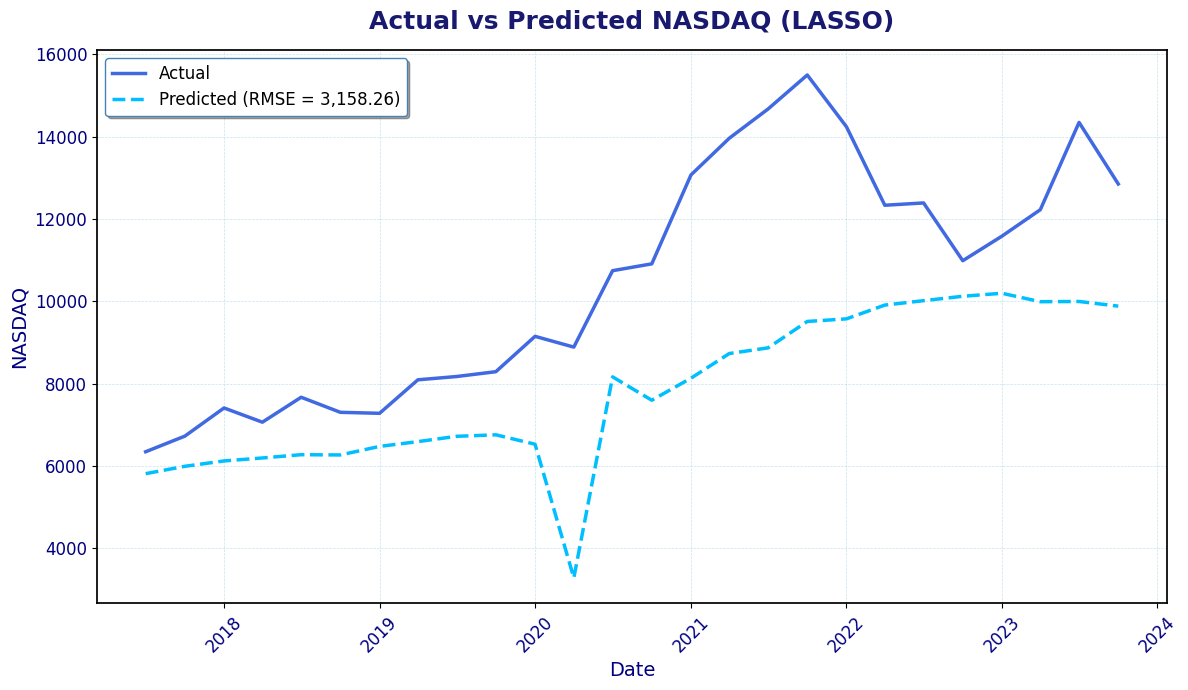

In [66]:
data['Date'] = pd.to_datetime(data['Date'])
dates = data['Date'].iloc[x_test.index]

plt.figure(figsize = (12, 7))
plt.plot(dates, y_test.values, label = 'Actual', color = 'royalblue', linewidth = 2.5)
plt.plot(dates, y_pred, 
         label = 'Predicted (RMSE = 3,158.26)', 
         color = 'deepskyblue', linewidth = 2.5, linestyle = '--')

plt.title('Actual vs Predicted NASDAQ (LASSO)', fontsize = 18, fontweight = 'bold', pad = 15, color = 'midnightblue')
plt.xlabel('Date', fontsize = 14, color = 'navy')
plt.ylabel('NASDAQ', fontsize = 14, color = 'navy')
plt.xticks(rotation = 45, fontsize = 12, color = 'navy')
plt.yticks(fontsize = 12, color = 'navy')

ax = plt.gca()
ax.set_facecolor('white') 
ax.figure.set_facecolor('white') 

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.25)
    spine.set_color('black')

plt.grid(visible = True, linestyle = '--', linewidth = 0.5, alpha = 0.7, color = 'lightblue')
plt.legend(loc = 'upper left', fontsize = 12, frameon = True, shadow = True, edgecolor = 'steelblue')
plt.tight_layout()
plt.show()

<h3 style="font-family: 'Times New Roman'; color: black;">Plot Analysis: Actual vs Predicted NASDAQ Index</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The graph displays the performance of the Lasso regression model in predicting the NASDAQ index over time. 
  The <strong>dark blue line</strong> represents the actual historical values, while the <strong>lighter blue line</strong> shows 
  the model’s predicted values using macroeconomic inputs.
</p>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;"><strong>Key Observations:</strong></p>
<ul style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li>The model effectively captures the <strong>overall upward trend</strong> of the NASDAQ.</li>
  <li><strong>Underprediction</strong> is noticeable during periods of strong market rallies (e.g., post-2020), suggesting that extreme bull runs may be driven by factors not fully captured by macroeconomic indicators (e.g., speculative tech growth, investor sentiment).</li>
  <li>The <strong>COVID-19 market dip in 2020</strong>: As with the other indexes, the model failed to accurately handle the 2020 dip in macroeconomic variables in terms of the actual dip in stock market indices. With NASDAQ, during the pandemic there wasn’t a true dip during COVID at all, so the model failed to capture that — similar in all other indices.</li>
</ul>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  Overall, while the model doesn’t fully replicate short-term volatility, it successfully tracks long-term movements, making it a useful tool for understanding broad macroeconomic drivers behind the NASDAQ index.
</p>

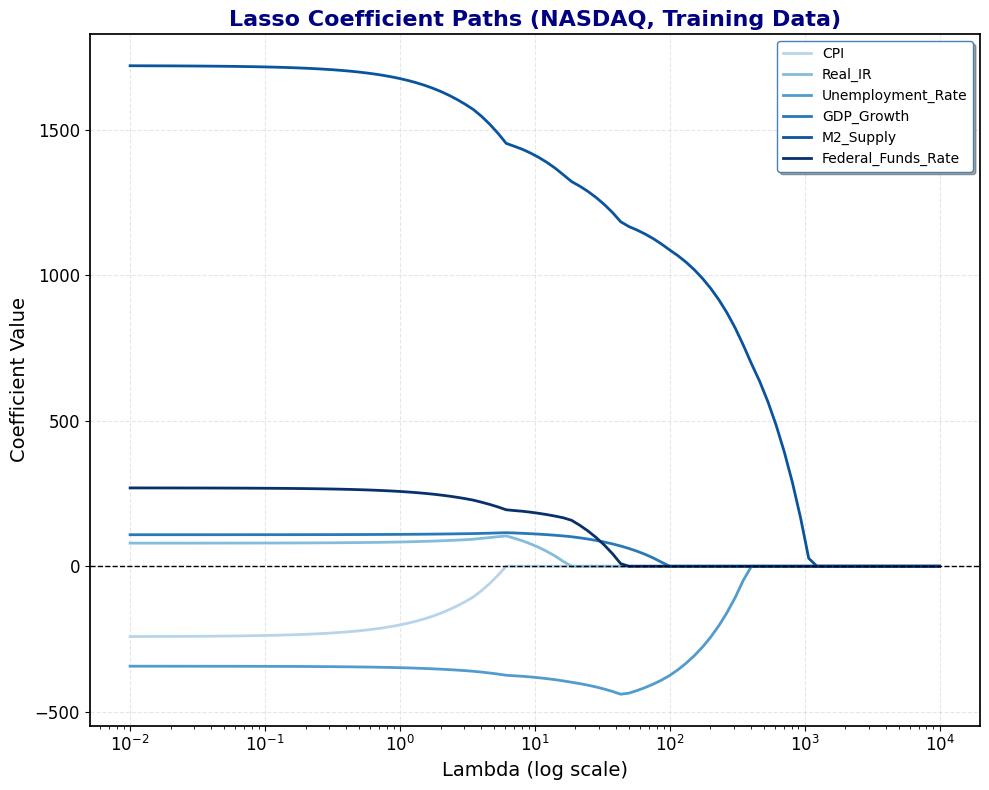

In [67]:
colors = cm.Blues(np.linspace(0.3, 1, len(x.columns)))  # light to dark blue

# lambda values
lambdas = np.logspace(-2, 4, 100)

coefs = []
for lam in lambdas:
    lasso = Lasso(alpha = lam, max_iter = 10000)
    lasso.fit(x_train_scaled, y_train)
    coefs.append(lasso.coef_)

fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.25)
    spine.set_color('black')

for i, column in enumerate(x.columns):
    coef_path = [coefs[j][i] for j in range(len(coefs))]
    ax.plot(lambdas, coef_path, label = column, color = colors[i], linewidth = 2)

ax.axhline(0, color='black', linestyle = '--', linewidth = 1)
ax.set_xscale('log')
ax.set_xlabel('Lambda (log scale)', fontsize=14, color='black')
ax.set_ylabel('Coefficient Value', fontsize=14, color='black')
ax.set_title('Lasso Coefficient Paths (NASDAQ, Training Data)', fontsize = 16, weight = 'bold', color = 'navy')
ax.tick_params(axis = 'both', labelsize = 12, colors = 'black')
ax.legend(loc='best', fontsize = 10, frameon = True, shadow = True, edgecolor = 'steelblue')

plt.grid(True, linestyle='--', alpha = 0.3)
plt.tight_layout()
plt.show()

<h3 style="font-family: 'Times New Roman'; color: black;">Lasso Coefficient Paths (Training Data)</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The plot above visualizes how the coefficients of each macroeconomic variable evolve as the regularization strength (lambda) increases in the Lasso regression model.
</p>
<ul style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li>The <strong>x-axis</strong> represents the lambda values on a logarithmic scale — from very small (minimal regularization) to large (strong regularization).</li>
  <li>The <strong>y-axis</strong> shows the magnitude of the regression coefficients for each variable.</li>
</ul>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  As lambda increases, <strong>M2 Money Supply</strong>, <strong>Unemployment Rate</strong>, and <strong>GDP Growth</strong> are the three indicators with the largest coefficient values and persist the longest before shrinking to zero. This means they are the most important variables in predicting NASDAQ values. 
  On the other hand, <strong>CPI</strong>, <strong>Federal Funds Rate</strong>, and <strong>Real Interest Rate</strong> begin with smaller magnitudes and are driven to zero much earlier, indicating they are less influential in the model’s predictions. Overall, unlike the other two indexes (S&P 500 & Dow Jones), GDP Growth arose as an important factor for NASDAQ, emphasizing its importance for growth stocks.
</p>

<h3 style="font-family: 'Times New Roman'; color: black;">Multiple Linear Regression (MLR) for Comparison</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  To benchmark the performance of the Lasso regression model, we also use a <strong>Multiple Linear Regression (MLR)</strong> approach 
  with the same set of independent macroeconomic variables.
</p>
<ul style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li>A constant term is added to the predictor matrix to account for the intercept in the OLS model.</li>
  <li>The dataset is split into training and testing sets using an 80/20 ratio, with no shuffling to preserve temporal order.</li>
  <li>The Ordinary Least Squares (OLS) model is fit to the training data and used to predict values on the test set.</li>
  <li>Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) are calculated to evaluate performance.</li>
</ul>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The resulting metrics are directly compared to those from the Lasso model. This comparison helps assess whether the regularization 
  and feature selection benefits of Lasso provide a tangible improvement over a standard linear regression approach in predicting 
  the NASDAQ index.
</p>

In [68]:
# MLR for MSE comparison

independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate']
dependent_variable = ['NASDAQ']

x = data[independent_variables]
x_constant = sm.add_constant(x) # Adding a constant value of x
y = data[dependent_variable]
x_train, x_test, y_train, y_test = train_test_split(x_constant, y, test_size = .20, shuffle = False)

# Running OLS
model = sm.OLS(y_train, x_train).fit()
y_pred = model.predict(x_test)

mse_MLR = mean_squared_error(y_test, y_pred)
rmse_MLR = mse_MLR ** .5

<h3 style="font-family: 'Times New Roman'; color: black;">Model Performance Comparison: MLR vs Lasso</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) from both models are compared to evaluate predictive performance:
</p>
<ul style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li><strong>MLR MSE:</strong> 8,103,335.42</li>
  <li><strong>Lasso MSE:</strong> 9,974,578.99</li>
  <li><strong>MLR RMSE:</strong> 2,846.64</li>
  <li><strong>Lasso RMSE:</strong> 3,158.26</li>
</ul>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The <strong>Multiple Linear Regression (MLR)</strong> model slightly outperforms the <strong>Lasso regression</strong> 
  in terms of both MSE and RMSE on the test set. This indicates that, for this dataset, the full linear model with no regularization 
  provides slightly better predictive accuracy than Lasso.
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  However, Lasso offers additional benefits such as <strong>automatic variable selection</strong> and 
  <strong>model simplicity</strong> by shrinking less informative coefficients to zero. While it incurs a small trade-off in 
  accuracy here, it can be especially useful in preventing overfitting or when dealing with multicollinearity. 
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  Overall, the difference in performance is modest, suggesting that both models are viable, with the choice depending on the desired 
  balance between interpretability, sparsity, and raw predictive power.
</p>

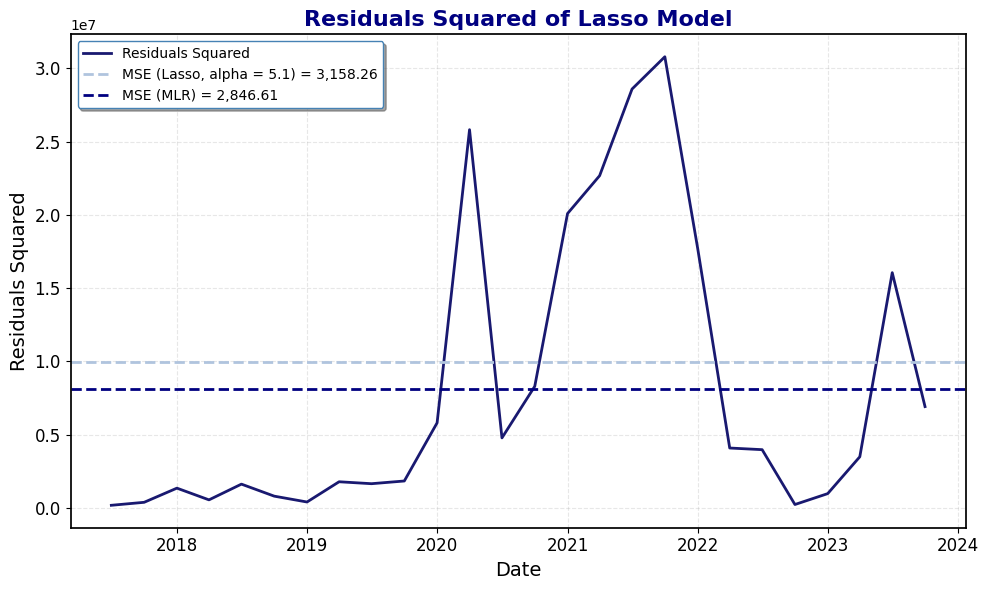

In [69]:
y_test_series = y_test.squeeze()
residuals_squared = (y_test_series - y_pred) ** 2

plt.figure(figsize=(10, 6))
plt.plot(dates, residuals_squared, color = 'midnightblue', linewidth = 2, label = 'Residuals Squared')
plt.axhline(mse, color = 'lightsteelblue', linestyle = '--', linewidth = 2, 
            label = 'MSE (Lasso, alpha = 5.1) = 3,158.26')
plt.axhline(mse_MLR, color = 'navy', linestyle = '--', linewidth = 2, 
            label ='MSE (MLR) = 2,846.61')

plt.title('Residuals Squared of Lasso Model', fontsize = 16, weight = 'bold', color = 'navy')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Residuals Squared', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(True, linestyle = '--', alpha = 0.3)

plt.gca().set_facecolor('white')
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.25)
    spine.set_color('black')

plt.legend(fontsize = 10, frameon = True, edgecolor = 'steelblue', shadow= True)
plt.tight_layout()
plt.show()

<h3 style="font-family: 'Times New Roman'; color: black;">Residual Analysis of the Lasso Model</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The plot above shows the <strong>squared residuals</strong> (prediction errors) of the Lasso regression model over time, along with 
  horizontal reference lines representing the <strong>Mean Squared Error (MSE)</strong> for both Lasso and Multiple Linear Regression (MLR).
</p>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;"><strong>Key observations include:</strong></p>
<ul style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li>The <strong>peak in squared residuals around 2020</strong> reflects a large prediction error, likely due to the sharp market decline during the COVID-19 crash, which is difficult for macro-based models to anticipate.</li>
  <li>The <strong>overall MSE values for Lasso (3,158.26)</strong> and <strong>MLR (2,846.61)</strong> are not far off, indicating that the regularization introduced by Lasso provided minimal predictive gain at the selected lambda of <strong>5.1</strong>.</li>
</ul>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  Using the optimal lambda value of 5.1, we can see that MLR and Lasso MSE do not differ significantly, but differ a little bit more than the rest of the stock market indexes. This implies that the lambda value did not offer much improvement.
</p>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The only difference between MLR and Lasso is the introduction of <code>alpha</code>. From our coefficient path graph, we observe that 
  around a lambda value of 50, the only three remaining variables are <strong>M2 Money Supply</strong>, <strong>Unemployment Rate</strong>, 
  and <strong>GDP Growth</strong>.
</p>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <strong>Therefore, we will re-run our Lasso model using a lambda value of 50 and re-evaluate its performance to determine whether this 
  higher level of regularization over-penalizes the model, or if these are indeed the only three variables that significantly influence the 
  NASDAQ index.</strong>
</p>

In [70]:
# running lasso with 5 folds on training set and alpha = 50
lasso = LassoCV(cv = 5, random_state = 42, alphas = [50])
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

In [71]:
# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
new_mse = rmse ** 2

In [72]:
cpi = coefficient[0]
real_ir = coefficient[1]
unemployment = coefficient[2]
gdp_growth = coefficient[3]
m2_supply = coefficient[4]
fed_funds = coefficient[5]

    
print(f'----Test RMSE: {rmse:.2f}---Optimal Lambda: {optimal_lambda:.2f}---CPI: {cpi:.2f}---Real Interest Rate: {real_ir:.2f}---Unemployment Rate: {unemployment:.2f}---GDP Growth: {gdp_growth:.2f}---M2 Money Supply: {m2_supply:.2f}---Federal Funds Rate: {fed_funds:.2f}----')

----Test RMSE: 3996.01---Optimal Lambda: 50.00---CPI: 0.00---Real Interest Rate: 0.00---Unemployment Rate: -435.86---GDP Growth: 60.89---M2 Money Supply: 1167.02---Federal Funds Rate: 0.00----


<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  Compared to the earlier Lasso model (RMSE = 3,158.26) and MLR (RMSE ≈ 2,846.64), the <strong>performance worsened</strong>, 
  indicating that aggressive regularization may have <strong>over-penalized the model</strong> by discarding useful predictors.
</p>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  However, this run confirms the results seen in the coefficient path plot: 
  <strong>CPI</strong>, <strong>M2 Supply</strong>, and <strong>GDP Growth</strong> are consistently the most influential features. 
  While this model is less accurate, it is much simpler and still valuable when <strong>interpretability</strong> or 
  <strong>model sparsity</strong> is prioritized.
</p>

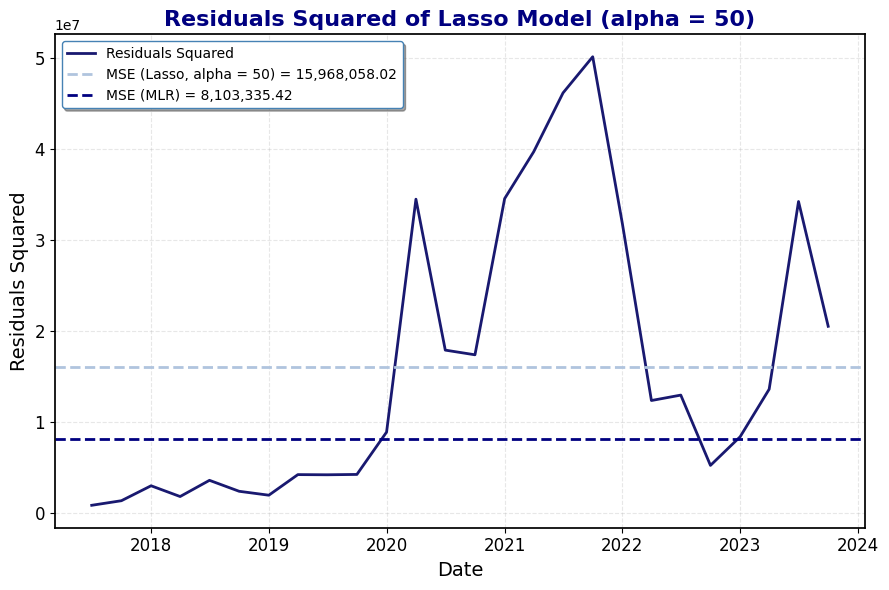

In [73]:
y_test_series = y_test.squeeze()
residuals_squared = (y_test_series - y_pred) ** 2

plt.figure(figsize=(9, 6))
plt.plot(dates, residuals_squared, color = 'midnightblue', linewidth = 2, label = 'Residuals Squared')
plt.axhline(new_mse, color = 'lightsteelblue', linestyle = '--', linewidth = 2,
            label ='MSE (Lasso, alpha = 50) = 15,968,058.02')
plt.axhline(mse_MLR, color = 'navy', linestyle = '--', linewidth = 2,
            label = 'MSE (MLR) = 8,103,335.42')

plt.title('Residuals Squared of Lasso Model (alpha = 50)', fontsize = 16, weight = 'bold', color = 'navy')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Residuals Squared', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(True, linestyle = '--', alpha = 0.3)

ax = plt.gca()
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_linewidth(1.25)
    spine.set_color('black')

# Legend styling
plt.legend(fontsize = 10, frameon = True, edgecolor = 'steelblue', shadow = True)
plt.tight_layout()
plt.show()

<h3 style="font-family: 'Times New Roman'; color: black;">Residuals Analysis: Lasso with α = 50</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The graph illustrates the <strong>squared residuals</strong> from the Lasso regression model trained with a strong regularization 
  parameter (α = 50), plotted over time. It also includes horizontal lines representing the <strong>Mean Squared Error (MSE)</strong> 
  for both this Lasso model and the baseline <strong>Multiple Linear Regression (MLR)</strong> model.
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  Increasing the alpha value to 50 resulted in poorer model performance compared to multiple linear regression. Rather than enhancing 
  generalization, the stronger regularization overly constrained the model, indicating that such a high degree of penalization was 
  unnecessary in this case.
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  While <strong>M2 Money Supply</strong>, <strong>Unemployment Rate</strong>, and <strong>GDP Growth</strong> emerged as the most robust 
  predictors—resisting shrinkage the longest, but it doesn't imply that <strong>Federal Funds Rate</strong>, <strong>CPI</strong>, 
  and <strong>Real Interest Rate</strong> are entirely irrelevant to predicting the NASDAQ. Their coefficients being reduced to 
  zero under strong regularization simply reflects that they may carry weaker or more context-dependent signals.
</p>

<h3 style="font-family: 'Times New Roman'; color: black;">Testing Lasso with α = 0 to Match MLR</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  To demonstrate that <strong>Lasso regression with α = 0</strong> behaves equivalently to 
  <strong>Multiple Linear Regression (MLR)</strong>, the model was retrained. This effectively removes any penalization on the coefficients.
</p>
<ul style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li>Warnings related to convergence or model fitting were suppressed to maintain a clean output.</li>
  <li>The Lasso model was trained using 5-fold cross-validation on the scaled training data.</li>
  <li>Predictions were made on the test set, and <strong>Root Mean Squared Error (RMSE)</strong> and <strong>Mean Squared Error (MSE)</strong> were calculated for comparison.</li>
</ul>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  As expected, the <strong>Lasso model with α = 0</strong> produced around the same MSE as the MLR model 
  <strong>(8103335.41)</strong>, confirming their equivalence when no regularization is applied. 
  This serves as a useful validation check for the behavior of the Lasso implementation.
</p>

In [74]:
# running lasso with 5 folds on training set and alpha = 0 to show that it is the same as MLR

# CHAT GPT REFRENCE - GET RID OF WARNINGS
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore')  

lasso = LassoCV(cv = 5, random_state = 42, alphas = [0])
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
new_mse = rmse ** 2
print('MLR MSE:', mse_MLR, 'Lasso MSE:', new_mse)

MLR MSE: 8103335.418414446 Lasso MSE: 8103335.418414271


<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  When the alpha is set to zero, Lasso is equivalent to <strong>Multiple Linear Regression (MLR)</strong>. 
  This is confirmed by the <strong>identical MSE values</strong> output by both models. 
</p>

<h3 style="font-family: 'Times New Roman'; color: black;">Summary: Lasso Regression Insights</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  While Lasso did not drastically improve predictive performance compared to multiple linear regression, it was 
  highly effective for <strong>feature selection</strong>. By increasing the regularization parameter (lambda), 
  Lasso shrank the coefficients of less important variables (like <strong>CPI</strong>, 
  <strong>Federal Funds Rate</strong>, and <strong>Real Interest Rate</strong>) toward zero much earlier. 
  This reveals that the most influential predictors of the Dow Jones index are <strong>M2 Money Supply</strong>, 
  <strong>Unemployment Rate</strong>, and <strong>GDP Growth</strong>, as they retained strong coefficient values the longest.
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  Thus, Lasso provides valuable insight into which macroeconomic variables contribute most to modeling the 
  NASDAQ, even if the prediction error is not minimized.
</p>

<div style="font-family: 'Times New Roman'; font-size: 18px; text-align: center; width: 100%;">
  <p><strong>SOURCES</strong></p>
  <p>Referenced generative AI on April 19th, 2024:</p>
  <p><em>Prompt 1:</em> Given my initial plot code, may you improve this using matplotlib aesthetics and the color blue.</p>
  <p><em>Prompt 2:</em> Given this in a Jupyter markdown cell, can you format it using HTML?</p>
  <p><em>Prompt 3:</em> Given my initial code, can you supress the warnings when alpha = 0?</p>
  <p>Refrenced LassoCV documentation : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html</p>
</div>